In [23]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import color as sk_col
from skimage.filters import threshold_otsu

In [24]:
# image size resizing

def resize_image(image, target_size=(128, 128), bg_color='white'):
    from PIL import Image
    image.thumbnail(target_size, Image.ANTIALIAS)
    new_image = Image.new("RGB", target_size, bg_color)
    new_image.paste(image, (int((target_size[0] - image.size[0]) / 2), int((target_size[1] - image.size[1]) / 2)))

    return new_image

In [25]:
# train_folder = r'D:\AI\code\Azure_notebook_data\medical images predictions\dataset\segmented_data_array'
train_folder = r'C:\Users\tamim\Desktop\Parse Segment\Dataset\Original Images'
images = []
gray_images = []
labels = []
classes = []

for root, folders, files in os.walk(train_folder):
    #print(root)
    #print(folders)
    #print(files)
    for j, folder in enumerate(folders):
        files_in_folder = os.listdir(os.path.join(root, folder))
        classes.append(folder)
        print('==>  Processing '+str(folder) + ' folder')
#         print(files_in_folder)
        for i, file in enumerate(files_in_folder):
            file_path = os.path.join(root, folder, file)
            image = Image.open(file_path)
            image_array = np.array(resize_image(image,target_size=(224,224)))
        
            images.append(image_array)
print('Task completed....!')

==>  Processing CT_BH folder
==>  Processing DynaCT_BH folder
Task completed....!


In [26]:
# data scale to 0 - 1
images_array = np.array(images)/225.

In [27]:
# seperate ct and dct data
CT_images = images_array[0:700]
DCT_images = images_array[700:]
print(CT_images.shape)
print(DCT_images.shape)

(700, 224, 224, 3)
(497, 224, 224, 3)


# VGG16 model for fearture extraction

In [28]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import layers

vgg16_model = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=True)
print(vgg16_model.summary())
input_layer = vgg16_model.input
last_layer_avg_pooling = vgg16_model.get_layer('block5_pool').output
global_avg_pooling = layers.GlobalAveragePooling2D()(last_layer_avg_pooling)
vgg16_features = Model(inputs = input_layer, outputs = global_avg_pooling)
print(vgg16_features.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Features extraction using VGG16

In [ ]:
CT_features = vgg16_features.predict(CT_images)
DCT_features = vgg16_features.predict(DCT_images)
print(CT_features.shape)
print(DCT_features.shape)

 7/22 [========>.....................] - ETA: 51s

### defining the function for matrics meaurement and graph respresentation

In [8]:
def metrics_measure(metric, d1, d2, data_type = 'segmented', image_type='ct', metric_name='cosine'):
    # for metric=metric what want to calculate
    # d1 = d1 data
    # d2 = d2 data
    # data_type = 'either orignal or segmented'
    # metric_name = set for other than cosine, defualt is consine
    
#     dist = metric(d1, d2)
    indexes = []
    values = []
    if metric_name == 'cosine':
        dist = metric(d1, d2)
        for i in range(dist.shape[0]):
            co_s = dist[i].max()
            v = dist[i].argmax()
            indexes.append((i, v))
            values.append(co_s)
#             print('d1 image indexed at {} and d2 image indexed at {} has maximum {} similarity: {}'.format(i, v,metric_name ,co_s))
    
    elif metric_name=='ssim':
        for i, d1_img in enumerate(d1):
            ssim_stack = []
            for j, d2_img in enumerate(d2):
        
                img1 = tf.convert_to_tensor(d1_img, dtype=tf.float32)
                img2 = tf.convert_to_tensor(d2_img, dtype=tf.float32)

                ssim = metric(img1, img2, max_val=1.0, filter_size=3)
                ssim_stack.append(ssim.numpy())
            indexes.append((i, np.array(ssim_stack).argmin()))
            values.append(np.array(ssim_stack).min())

    else:
        dist = metric(d1, d2)
        for i in range(dist.shape[0]):
            co_s = dist[i].min()
            v = dist[i].argmin()
            indexes.append((i, v))
            values.append(co_s)
#             print('d1 image indexed at {} and d2 image indexed at {} has minmum {}: {}'.format(i, v, metric_name,co_s))

        
    value_min = np.array(values).min()
    value_max = np.array(values).max()
    value_mean = np.array(values).mean()
    value_std = np.array(values).std()
    print('Min of {}: {}'.format(metric_name, value_min))
    print('Max of {}: {}'.format(metric_name, value_max))
    print('Mean of {}: {}'.format(metric_name, value_mean))
    print('Std of {}: {}'.format(metric_name, value_std))
    
    
    if data_type == 'segmented':
        if image_type =='ct':
            d1_name = 'CT segmented'
        elif image_type=='dct':
            d1_name = 'DCT segmented'
        else:
            d1_name = 'data'
    
    elif data_type =='orignal':
        if image_type == 'ct':
            d1_name = 'CT orignal'
        elif image_type == 'dct': 
            d1_name = 'DCT orignal'
        else:
            d1_name = 'data'
        
    
    
#     indxs, values, _, _ = eucl_sim
#     print(values.shape)

    fig = plt.figure(figsize=(8,6))
    plt.plot(np.array(values))

    plt.xlabel(f'{d1_name} images')
    plt.ylabel('Error')
    plt.title(f'variation in error accros {d1_name} images for {metric_name}')
    plt.show()
    
    
    
    return indexes, np.array(values), value_mean, value_std

## VGG16: Similarity Measure and graph representation for CT orignal Images

Min of cosine: 0.9628799557685852
Max of cosine: 0.9896085858345032
Mean of cosine: 0.9718552827835083
Std of cosine: 0.005737616214901209


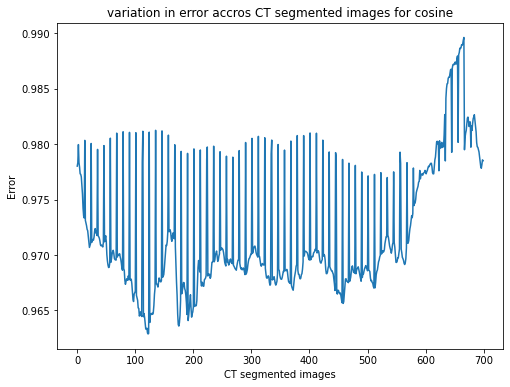

Min of euclidean distance: 1.6482877731323242
Max of euclidean distance: 3.2610764503479004
Mean of euclidean distance: 2.769336700439453
Std of euclidean distance: 0.3218742609024048


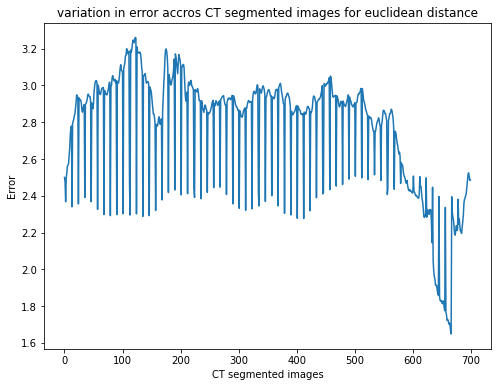

In [9]:
from sklearn import metrics
cosine_sim = metrics_measure(metrics.pairwise.cosine_similarity, CT_features, DCT_features, data_type = 'segmented', image_type='ct')
eucl_sim = metrics_measure(metrics.pairwise.euclidean_distances, CT_features, DCT_features, data_type = 'segmented', image_type='ct', metric_name='euclidean distance')

## VGG16: Similarity Measure and graph representation for CT orignal Images

Min of cosine: 0.975215494632721
Max of cosine: 0.9896085858345032
Mean of cosine: 0.9816380143165588
Std of cosine: 0.0022406289353966713


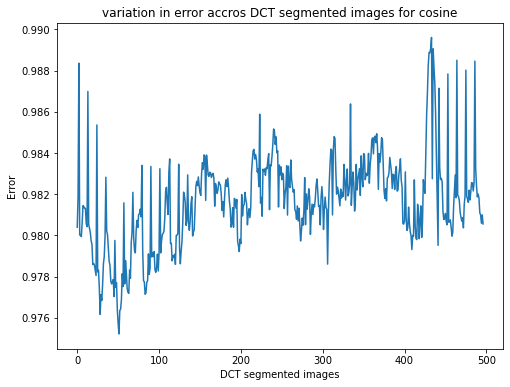

Min of euclidean distance: 1.6482877731323242
Max of euclidean distance: 2.5764100551605225
Mean of euclidean distance: 2.2086119651794434
Std of euclidean distance: 0.1418904960155487


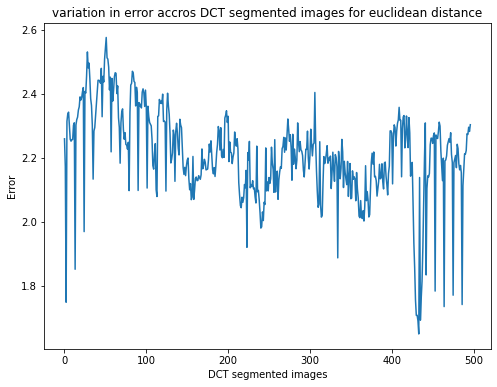

In [10]:
cosine_sim = metrics_measure(metrics.pairwise.cosine_similarity, DCT_features, CT_features, data_type = 'segmented', image_type='dct')
eucl_sim = metrics_measure(metrics.pairwise.euclidean_distances, DCT_features, CT_features, data_type = 'segmented', image_type='dct', metric_name='euclidean distance')

# Apply PCA for vgg16

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
CT_vgg16_components = pca.fit_transform(CT_features)
DCT_vgg16_components = pca.transform(DCT_features)
print(CT_vgg16_components.shape)
print(DCT_vgg16_components.shape)

(700, 2)
(497, 2)


## VGG16: Similarity Measure after PCA and graph representation for CT orignal Images

Min of cosine: -0.788634717464447
Max of cosine: 1.0000001192092896
Mean of cosine: 0.2880675494670868
Std of cosine: 0.5945889353752136


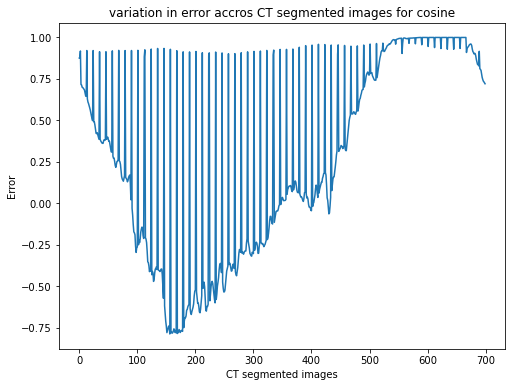

Min of euclidean distance: 0.035776861011981964
Max of euclidean distance: 1.6726205348968506
Mean of euclidean distance: 1.058052659034729
Std of euclidean distance: 0.4868098497390747


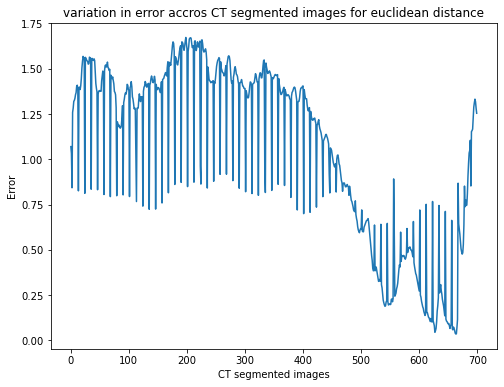

In [12]:
cosine_sim = metrics_measure(metrics.pairwise.cosine_similarity, CT_vgg16_components, DCT_vgg16_components, data_type = 'segmented', image_type='ct')
eucl_sim = metrics_measure(metrics.pairwise.euclidean_distances, CT_vgg16_components, DCT_vgg16_components, data_type = 'segmented', image_type='ct', metric_name='euclidean distance')

## VGG16: Similarity Measure after PCA and graph representation for DCT orignal Images

Min of cosine: 0.8254871368408203
Max of cosine: 1.0000001192092896
Mean of cosine: 0.9564164280891418
Std of cosine: 0.05211666226387024


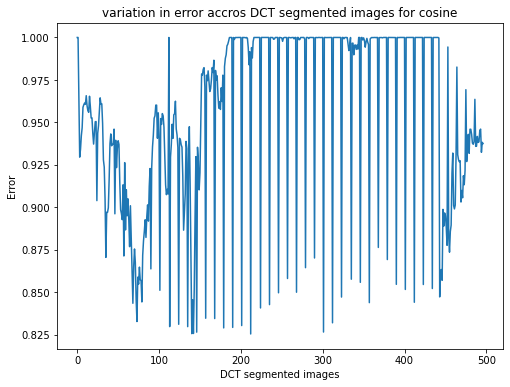

Min of euclidean distance: 0.035776861011981964
Max of euclidean distance: 1.0626170635223389
Mean of euclidean distance: 0.6329261064529419
Std of euclidean distance: 0.2211902141571045


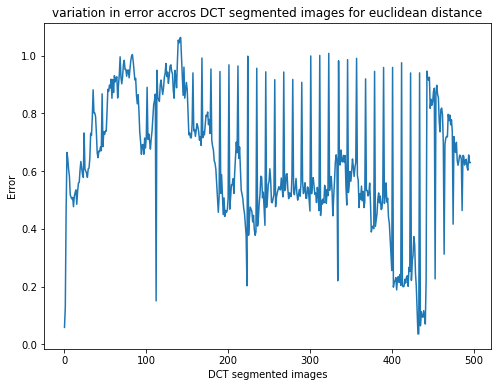

In [13]:
cosine_sim = metrics_measure(metrics.pairwise.cosine_similarity, DCT_vgg16_components, CT_vgg16_components, data_type = 'segmented', image_type='dct')
eucl_sim = metrics_measure(metrics.pairwise.euclidean_distances, DCT_vgg16_components, CT_vgg16_components, data_type = 'segmented', image_type='dct', metric_name='euclidean distance')


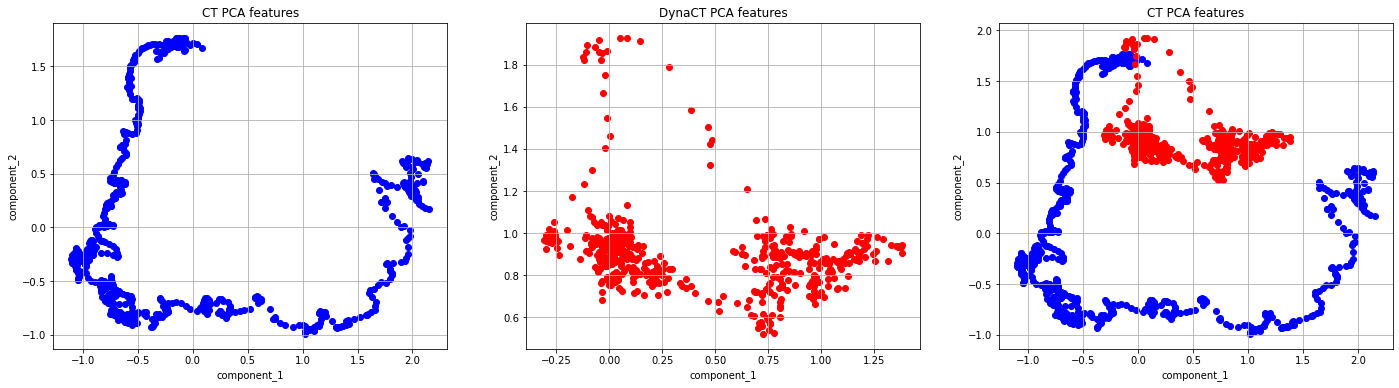

In [14]:
fig = plt.figure(figsize=(24,6))

a = fig.add_subplot(1,3,1)
plt.scatter(CT_vgg16_components[:,0], CT_vgg16_components[:,1], c='blue')
a.set_xlabel('component_1')
a.set_ylabel('component_2')
a.set_title('CT PCA features')
plt.grid()

a = fig.add_subplot(1,3,2)
plt.scatter(DCT_vgg16_components[:,0], DCT_vgg16_components[:,1], c='red')
a.set_xlabel('component_1')
a.set_ylabel('component_2')
a.set_title('DynaCT PCA features')
plt.grid()

a = fig.add_subplot(1,3,3)
plt.scatter(CT_vgg16_components[:,0], CT_vgg16_components[:,1], c='blue')
plt.scatter(DCT_vgg16_components[:,0], DCT_vgg16_components[:,1], c='red')
a.set_xlabel('component_1')
a.set_ylabel('component_2')
a.set_title('CT PCA features')
plt.grid()

plt.show()

# ResNet50

In [15]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=True)

input_layer = resnet.input
last_layer = resnet.get_layer('avg_pool').output
resnet50_features = Model(inputs = input_layer, outputs = last_layer)
print(resnet50_features.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [16]:
CT_resnet_features = resnet50_features.predict(CT_images)
DCT_resnet_features = resnet50_features.predict(DCT_images)

print(CT_resnet_features.shape)
print(DCT_resnet_features.shape)

16/16 [==============================] - 32s 2s/step
(700, 2048)
(497, 2048)


## ResNet: Similarity Measure and graph representation for CT orignal Images

Min of cosine: 0.9262542724609375
Max of cosine: 0.9917689561843872
Mean of cosine: 0.9545785188674927
Std of cosine: 0.01613014191389084


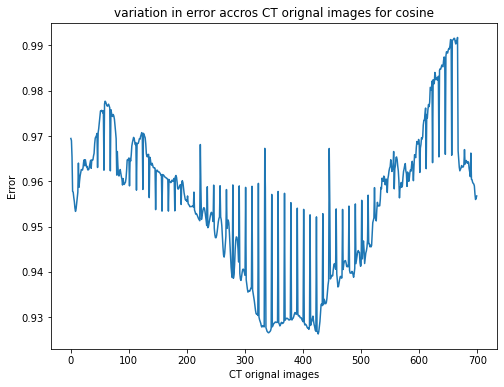

Min of euclidean distance: 3.623840570449829
Max of euclidean distance: 10.716242790222168
Mean of euclidean distance: 8.335874557495117
Std of euclidean distance: 1.5657931566238403


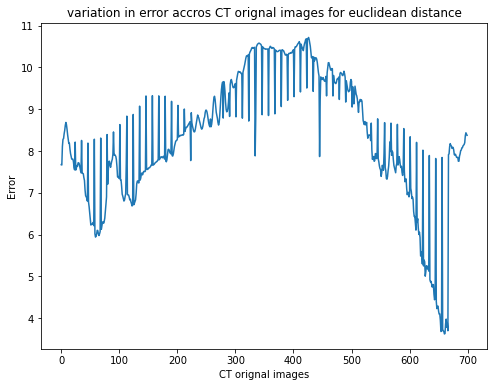

In [17]:
cosine_sim = metrics_measure(metrics.pairwise.cosine_similarity, CT_resnet_features, DCT_resnet_features, data_type='orignal', image_type = 'ct', metric_name='cosine')
eucl_sim = metrics_measure(metrics.pairwise.euclidean_distances, CT_resnet_features, DCT_resnet_features, data_type='orignal', image_type = 'ct', metric_name='euclidean distance')

## ResNet: Similarity Measure and graph representation for DCT orignal Images

Min of cosine: 0.9681780338287354
Max of cosine: 0.9917689561843872
Mean of cosine: 0.9852278828620911
Std of cosine: 0.005402759183198214


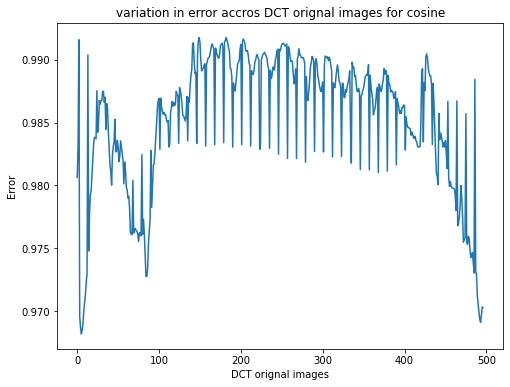

Min of euclidean distance: 3.623840570449829
Max of euclidean distance: 7.571185111999512
Mean of euclidean distance: 4.9405837059021
Std of euclidean distance: 0.858405351638794


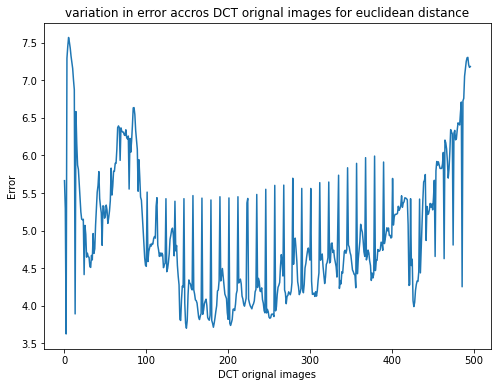

In [18]:
cosine_sim = metrics_measure(metrics.pairwise.cosine_similarity, DCT_resnet_features, CT_resnet_features, data_type='orignal', image_type = 'dct', metric_name='cosine')
eucl_sim = metrics_measure(metrics.pairwise.euclidean_distances, DCT_resnet_features, CT_resnet_features, data_type='orignal', image_type = 'dct', metric_name='euclidean distance')

# PCA for resnet50

In [19]:
pca_resnet = PCA(n_components=2)
CT_resnet_components = pca_resnet.fit_transform(CT_resnet_features)
DCT_resnet_components = pca_resnet.transform(DCT_resnet_features)
print(CT_resnet_components.shape)
print(DCT_resnet_components.shape)

(700, 2)
(497, 2)


## ResNet: Similarity Measure after PCA and graph representation for CT orignal Images

Min of cosine: -0.3143322467803955
Max of cosine: 1.0000001192092896
Mean of cosine: 0.7121245265007019
Std of cosine: 0.36387816071510315


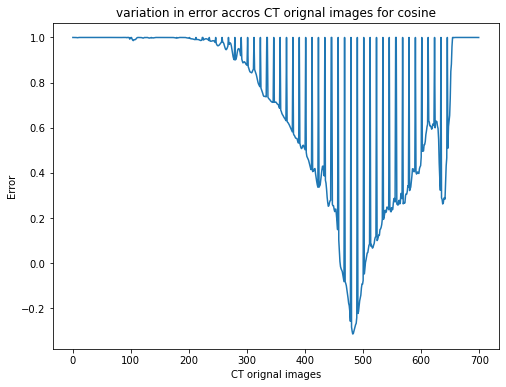

Min of euclidean distance: 0.03161398693919182
Max of euclidean distance: 6.022207260131836
Mean of euclidean distance: 3.7739474773406982
Std of euclidean distance: 1.6975674629211426


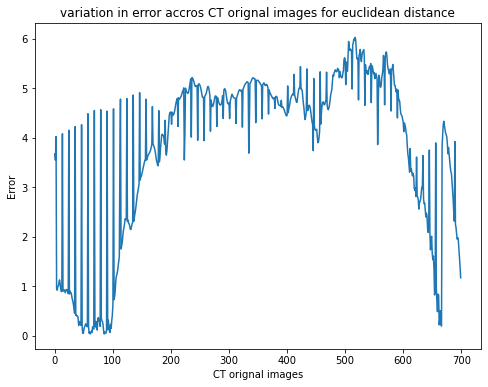

In [20]:
cosine_sim = metrics_measure(metrics.pairwise.cosine_similarity, CT_resnet_components, DCT_resnet_components, data_type='orignal', image_type='ct', metric_name='cosine')
eucl_sim = metrics_measure(metrics.pairwise.euclidean_distances, CT_resnet_components, DCT_resnet_components, data_type='orignal', image_type='ct', metric_name='euclidean distance')

## ResNet: Similarity Measure after PCA and graph representation for DCT orignal Images

Min of cosine: 0.9882807731628418
Max of cosine: 1.0000001192092896
Mean of cosine: 0.9994925856590271
Std of cosine: 0.0010814493289217353


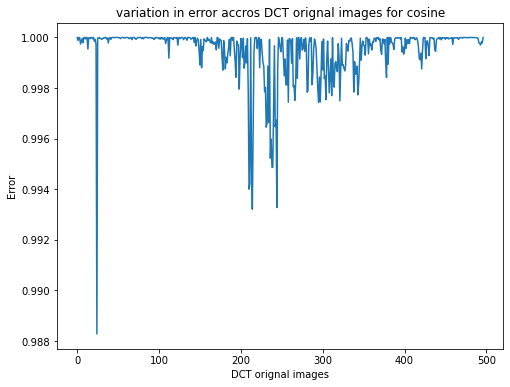

Min of euclidean distance: 0.03161398693919182
Max of euclidean distance: 1.6654607057571411
Mean of euclidean distance: 0.8023719787597656
Std of euclidean distance: 0.4210605025291443


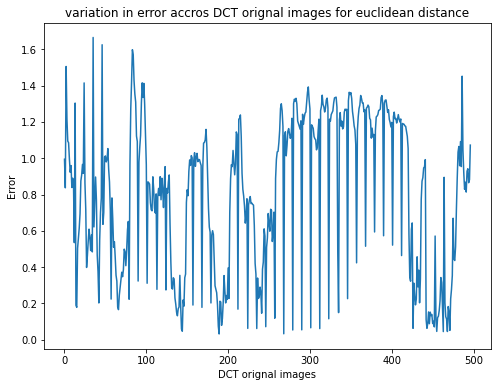

In [21]:
cosine_sim = metrics_measure(metrics.pairwise.cosine_similarity, DCT_resnet_components, CT_resnet_components, data_type='orignal', image_type='dct', metric_name='cosine')
eucl_sim = metrics_measure(metrics.pairwise.euclidean_distances, DCT_resnet_components, CT_resnet_components, data_type='orignal', image_type='dct', metric_name='euclidean distance')

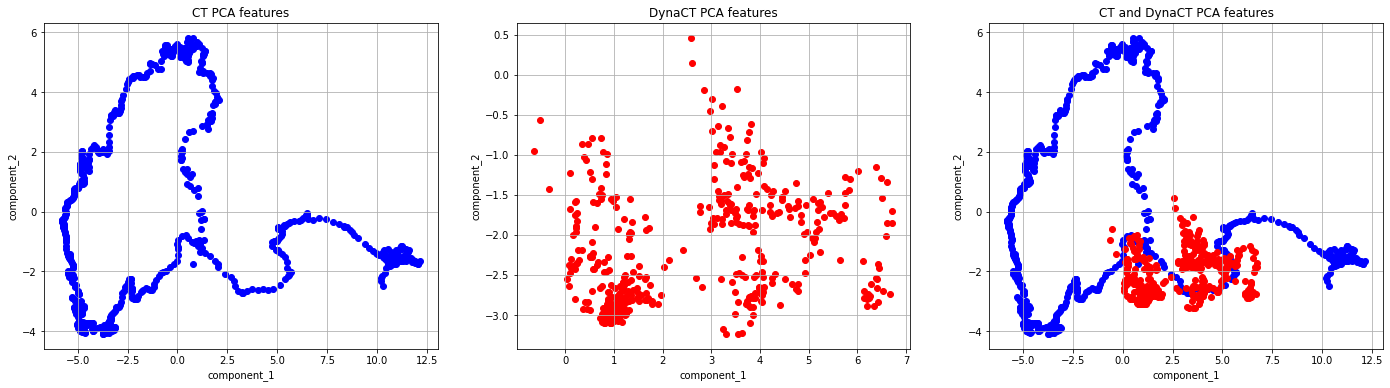

In [22]:
fig = plt.figure(figsize=(24,6))

a = fig.add_subplot(1,3,1)
plt.scatter(CT_resnet_components[:,0], CT_resnet_components[:,1], c='blue')
a.set_xlabel('component_1')
a.set_ylabel('component_2')
a.set_title('CT PCA features')
plt.grid()

a = fig.add_subplot(1,3,2)
plt.scatter(DCT_resnet_components[:,0], DCT_resnet_components[:,1], c='red')
a.set_xlabel('component_1')
a.set_ylabel('component_2')
a.set_title('DynaCT PCA features')
plt.grid()

a = fig.add_subplot(1,3,3)
plt.scatter(CT_resnet_components[:,0], CT_resnet_components[:,1], c='blue')
plt.scatter(DCT_resnet_components[:,0], DCT_resnet_components[:,1], c='red')
a.set_xlabel('component_1')
a.set_ylabel('component_2')
a.set_title('CT and DynaCT PCA features')
plt.grid()

plt.show()